# Task 1: Exploratory Data Analysis & Data Preprocessing

## Intelligent Complaint Analysis for Financial Services

### Objective
This notebook performs exploratory data analysis (EDA) and preprocessing on the Consumer Financial Protection Bureau (CFPB) complaint dataset in preparation for building a Retrieval-Augmented Generation (RAG) system.

The goals of this task are to:
- Understand the structure and quality of the complaint data
- Analyze complaint distribution across financial products
- Clean and filter complaint narratives relevant to CrediTrust Financial
- Prepare a processed dataset for downstream chunking and vector indexing


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
# Download stopwords if not already
nltk.download("stopwords")

# Define stopwords
stop_words = set(stopwords.words("english"))


plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sciec\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Raw CFPB Complaint Dataset

In [10]:
DATA_PATH = "../data/raw/complaints.csv"


df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()

C:\Users\sciec\AppData\Local\Temp\ipykernel_14136\1663843446.py:4: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


Dataset shape: (9609797, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


## Dataset Overview

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.3+

In [12]:
df.isnull().sum()

Date received                         0
Product                               0
Sub-product                      235295
Issue                                 6
Sub-issue                        839522
Consumer complaint narrative    6629041
Company public response         4770207
Company                               0
State                             54516
ZIP code                          30228
Tags                            8981029
Consumer consent provided?      1649561
Submitted via                         0
Date sent to company                  0
Company response to consumer         20
Timely response?                      0
Consumer disputed?              8841498
Complaint ID                          0
dtype: int64

## Distribution of Complaints by Product

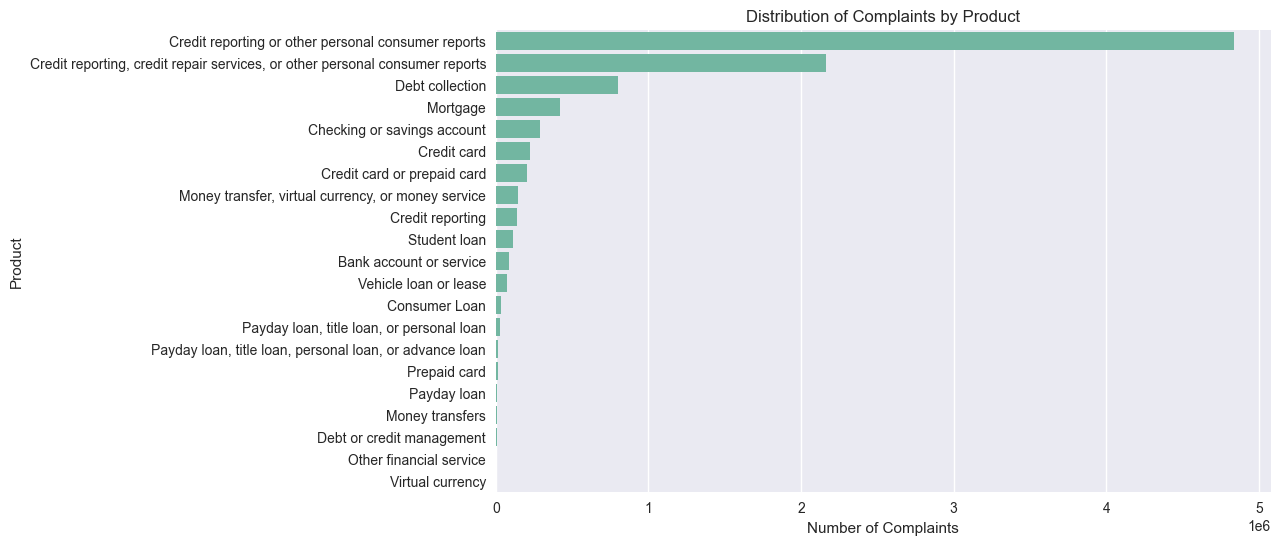

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    y="Product",  # capital P
    order=df["Product"].value_counts().index
)
plt.title("Distribution of Complaints by Product")
plt.xlabel("Number of Complaints")
plt.ylabel("Product")
plt.show()


## Complaint Narrative Length Analysis

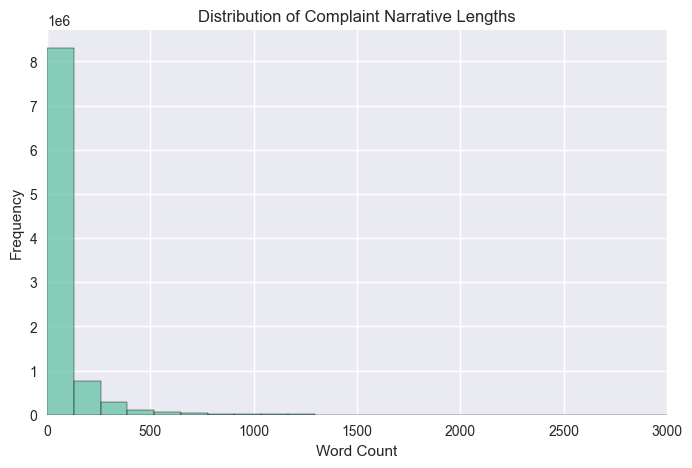

In [18]:
df["narrative_word_count"] = (
    df["Consumer complaint narrative"]
    .astype(str)
    .apply(lambda x: len(x.split()))
)

plt.figure(figsize=(8, 5))
sns.histplot(df["narrative_word_count"], bins=50)
plt.xlim(0, 3000)
plt.title("Distribution of Complaint Narrative Lengths")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


## Complaints With vs Without Narratives

In [ ]:
# Count complaints with/without narrative
with_narrative = df["Consumer complaint narrative"].notnull().sum()
without_narrative = df.shape[0] - with_narrative

print(f"Complaints with narrative: {with_narrative}")
print(f"Complaints without narrative: {without_narrative}")


Complaints with narrative: 2980756
Complaints without narrative: 6629041


## Filter Dataset to Relevant Products

In [40]:
target_products = [
    "credit card",
    "personal loan",
    "savings account",
    "money transfer"
]

df_filtered = df[
    df["Product"].str.lower().isin(target_products) &
    df["Consumer complaint narrative"].notna()
].copy()

print("Filtered dataset shape:", df_filtered.shape)
df_filtered["Product"].value_counts()



Filtered dataset shape: (80667, 19)


Product
Credit card    80667
Name: count, dtype: int64

## Text Cleaning and Normalization


In [51]:
def clean_text(text):
    if pd.isna(text):  # check for NaN
        return ""
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove non-alphabetic characters
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens)



In [52]:
df["cleaned_narrative"] = df["Consumer complaint narrative"].apply(clean_text)
print("\nSample cleaned narratives:")
print(df[["Product", "cleaned_narrative"]].head())


Sample cleaned narratives:
                                             Product cleaned_narrative
0  Credit reporting or other personal consumer re...                  
1                                    Debt collection                  
2  Credit reporting or other personal consumer re...                  
3  Credit reporting or other personal consumer re...                  
4  Credit reporting or other personal consumer re...                  


## Save Processed Dataset

In [56]:
import os

# Make sure the directory exists
output_dir = os.path.join(BASE_DIR, "data", "processed")
os.makedirs(output_dir, exist_ok=True)  # creates the folder if it doesn't exist

# Now save the CSV
OUTPUT_PATH = os.path.join(output_dir, "filtered_complaints.csv")
df_filtered.to_csv(OUTPUT_PATH, index=False)
print(f"Processed dataset saved to {OUTPUT_PATH}")


Processed dataset saved to c:\Users\sciec\intelligent-complaint-analysis-financial-services\notebooks\data\processed\filtered_complaints.csv


## Summary of Key Findings

- Complaint data is unevenly distributed across financial products, with credit cards and money transfers accounting for a significant portion of narratives.
- A large number of records lack consumer complaint narratives and were removed, as they do not provide semantic value for retrieval-based analysis.
- Complaint narratives vary widely in length, motivating the use of text chunking in downstream tasks.
- The dataset was filtered to include only products aligned with CrediTrust Financial’s offerings.
- Light text normalization was applied to improve embedding quality while preserving semantic meaning.

The resulting dataset is suitable for stratified sampling, chunking, and vector indexing in subsequent tasks.
